In [1]:
import numpy as np
import matplotlib.pyplot as plt


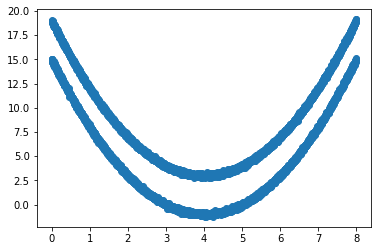

In [2]:
X = np.random.uniform(0,8,10000)
U = np.random.uniform(0,1,10000)
N1 = np.random.normal(3,0.1,10000)
N2 = np.random.normal(-1,0.1,10000)
Z = (X-4)**2
Z[U>=0.5] = Z[U>=0.5] + N1[U >= 0.5]
Z[U < 0.5] = Z[U < 0.5] + N2[U < 0.5]
fig, ax = plt.subplots(1,1)
ax.scatter(X,Z)

In [3]:
L = np.zeros(10000)
mask = Z >= (X-4)**2
L[mask] = 1
L[~mask] = 0

idx = np.random.permutation(np.arange(0,10000))
X_train = X[idx[0:int(0.8*10000)]]
X_test = X[idx[int(0.8*10000):]]

Z_train = Z[idx[0:int(0.8*10000)]]
Z_test = Z[idx[int(0.8*10000):]]

L_train = L[idx[0:int(0.8*10000)]]
L_test = L[idx[int(0.8*10000):]]

X_final_train = np.zeros((X_train.shape[0],2))
X_final_train[:,0]=X_train
X_final_train[:,1]=Z_train

X_final_test = np.zeros((X_test.shape[0],2))
X_final_test[:,0]=X_test
X_final_test[:,1]=Z_test

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
class CustomDataset(Dataset):
  def __init__(self, X, Y):
    self.X=X
    self.Y=Y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx,:], self.Y[idx]

  


In [6]:
training_set = CustomDataset(X_final_train, L_train)

In [7]:
len(training_set)

8000

In [8]:
training_set[0]

(array([1.3865655, 5.9273796]), 0.0)

In [9]:
test_set = CustomDataset(X_final_test, L_test)

In [10]:
training_dataloader = DataLoader(training_set,batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_set,batch_size=len(test_set), shuffle= True)

In [11]:
len(training_dataloader) # (dataset_size/batch_size)

32

In [12]:
batch_example=next(iter(training_dataloader)) #iterator through batch

In [13]:
batch_example[0].shape

torch.Size([256, 2])

In [14]:
batch_example[1].shape

torch.Size([256])

In [15]:
torch_example = torch.Tensor([[1,2,3,4],[5,6,7,8]])

In [16]:
torch_example

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])

In [17]:
torch_example.numpy()

array([[1., 2., 3., 4.],
       [5., 6., 7., 8.]], dtype=float32)

In [18]:
class NNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=2, out_features=10, bias = True)
    self.sigmoid_1 = torch.nn.Sigmoid()
    self.linear_2 = torch.nn.Linear(in_features=10, out_features=20, bias = True)
    self.sigmoid_2 = torch.nn.Sigmoid()
    self.linear_3 = torch.nn.Linear(in_features=20, out_features=1, bias = True)
    self.sigmoid_3 = torch.nn.Sigmoid()

  def forward(self, x):
    # X es el batch que va a entrar
    z1 = self.linear_1(x)
    a1 = self.sigmoid_1 (z1)
    z2 = self.linear_2(a1)
    a2 = self.sigmoid_2 (z2)
    z3 = self.linear_3(a2)
    y = self.sigmoid_3 (z3)
    return y

In [19]:
nnet = NNet()

In [20]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (sigmoid_1): Sigmoid()
  (linear_2): Linear(in_features=10, out_features=20, bias=True)
  (sigmoid_2): Sigmoid()
  (linear_3): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid_3): Sigmoid()
)


In [21]:
criterion = torch.nn.BCELoss(reduction='sum') # criterion. 'sum' suma todos los errores!
optimizer = torch.optim.SGD(nnet.parameters(),lr=0.001) # En realidad termina usando minibatch

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nnet.to(device)
for epoch in range(100):
  
  running_loss = 0

  for i, data in enumerate(training_dataloader):
    # data es una tupla batch (data, label)
    x, y = data #todavia esta en numpy
    x = x.to(device).float() #convierte a tensores y pasa a GPU si esta disponible
    y = y.to(device).float() #convierte a tensores y pasa a GPU si esta disponible

    # set gradient to zero
    optimizer.zero_grad()

    # forward
    y_hat = nnet(x)

    # loss
    loss = criterion(y_hat[:,0], y)
    
    # backward
    loss.backward()

    # update of parameters
    optimizer.step()

    # compute loss and statistics
    running_loss += loss.item()

  print(f"Epoch = {epoch} | loss = {running_loss/len(training_set)}")

Epoch = 0 | loss = 0.690952374458313
Epoch = 1 | loss = 0.6845313758850098
Epoch = 2 | loss = 0.6747721767425537
Epoch = 3 | loss = 0.6612342853546143
Epoch = 4 | loss = 0.6404845695495606
Epoch = 5 | loss = 0.6164362239837646
Epoch = 6 | loss = 0.5915887169837951
Epoch = 7 | loss = 0.5705803308486939
Epoch = 8 | loss = 0.5559158110618592
Epoch = 9 | loss = 0.5454750156402588
Epoch = 10 | loss = 0.5380280423164367
Epoch = 11 | loss = 0.5320586850643158
Epoch = 12 | loss = 0.5276221075057983
Epoch = 13 | loss = 0.52355464220047
Epoch = 14 | loss = 0.520801558971405
Epoch = 15 | loss = 0.5177747712135315
Epoch = 16 | loss = 0.514665723323822
Epoch = 17 | loss = 0.5129444818496705
Epoch = 18 | loss = 0.5115446157455444
Epoch = 19 | loss = 0.509164273262024
Epoch = 20 | loss = 0.5076807153224945
Epoch = 21 | loss = 0.5064175281524658
Epoch = 22 | loss = 0.505642216682434
Epoch = 23 | loss = 0.5033884031772613
Epoch = 24 | loss = 0.5027279996871948
Epoch = 25 | loss = 0.50036851978302
Epoch

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

Accuracy: 0.897
Recall: 1.0
Precision: 0.823327615780446
F1-Score: 0.9031044214487299


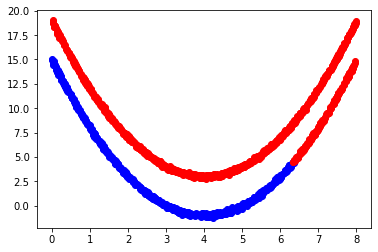

In [24]:
for i, data in enumerate(test_dataloader):
    x, y_real = data 
    x = x.to(device).float() 
    y_hat = (nnet(x)>=0.5)*1
    y_hat = y_hat[:,0]

    test_accuracy = accuracy_score(y_real,y_hat)
    test_recall = recall_score(y_real,y_hat)
    test_precision = precision_score(y_real, y_hat)
    test_f1 = f1_score(y_real,y_hat)
    print(f"Accuracy: {test_accuracy}")
    print(f"Recall: {test_recall}")
    print(f"Precision: {test_precision}")
    print(f"F1-Score: {test_f1}")

fig, ax = plt.subplots(1,1)
ax.scatter(x[y_hat==0,0],x[y_hat==0,1],c='blue')
ax.scatter(x[y_hat==1,0],x[y_hat==1,1],c='red')